<h1>Feature visualization in ST-GCN

In this project i explore feature visualization on graphs, and in particular over sequences of skeletons. I implemented some of the methods described in the project's [repository](https://distill.pub/2017/feature-visualization/), focusing on the following questions: can these methods be applied on such a different domain without much changing? And: do they actually help understanding what the model learns?

# Introduction

## ST-GCN in a nutshell

ST-GCN is an action-recognition model that applies GCN over human skeleton sequences.
<br>
<br>
It represents those sequence using both spatial and temporal edges: spatial edges are the natura connections along the skeleton's nodes, and the temporal edges connect each node to its next position (the position it will assume in the next frame)
<br>
<br>
Multiple layers of spatial temporal graph convolution
are constructed thereon, allowing information to be integrated along both the spatial and the temporal dimension

**Why did i chose ST-GCN?**
<br>
<br>
Given its nature, learned features are spatial or temporal, and the geometry of the graph (how it's connected, the number of nodes) heavily influences what the model learns. It's a bit like exploring point-clouds (because nodes are located in the space - they have 3D global coordinates), and a bit like exploring graphs (because, in fact, how the nodes are connected changes *a lot*)

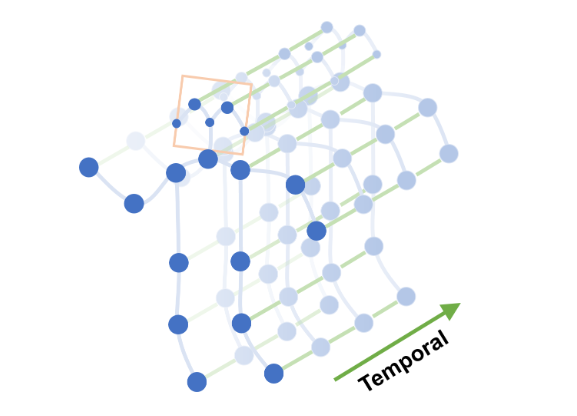

The code i used to implement it is from the official [github](https://github.com/yysijie/st-gcn) page

## Employed models and datasets

It's not mandatory to use the skeleton of a body: any graph sequence (that makes sense both temporally and spatially) can be used with **ST-GCN**, so i experimented with a dataset that has **hands** skeletal information
<br>
<br>
For the purpose of this project, i used various models over two datasets: [NTU-RGB+D 60](https://rose1.ntu.edu.sg/dataset/actionRecognition/) and [H2O](https://arxiv.org/pdf/2104.11181.pdf)
<br>
<br>
**NTU-RGB+D 60** is a famous dataset that contains ~60'000 video samples that include the following data: RGB videos, death map sequences, 3D skeletal body data and infrared videos; for each sample is provided the action label (over different 60 classes). For the purpose of this project, i used only 3D skeletal data 
<br>
<br>
**H2O** is a new dataset that provides video and 3D skeletal data of two hands and an object from a first-person viewpoint; it includes action labels over 37 classes

I tried various models: peak accuracy models, some overfitting ones, and in some i changed the priors. I will go in depth on this later on

## Related work?

As far as i know, there's no other work that explores feature visualization in the context of *geometric graphs* (where nodes contains geometrical information, such as the coordinates in space). 
<br>
What is more common is feature visualization on GCNs that work over graphs whose main features are the number of nodes and their connections ([eg.](https://www.lynxanalytics.com/blog/post/feature-visualization-on-a-graph-convolutional-network))

Another common feature visualization performed on graphs is the edge importance, and node importance. Since internet is saturated with such works, i will not explore them in this project

# Feature visualization: where to begin?

First of all, i wanted to implement different input optimizations as described in the project's [reference](https://distill.pub/2017/feature-visualization/) 
<br>
<br>
But of course, images are very very different from sequences of skeletons. For example, the reference starts by optimizing some random noise, but *what is* random noise in the context of skeleton sequences? 
<br>
<br>
Most of the code i used for the optimization comes form [this](https://github.com/utkuozbulak/pytorch-cnn-visualizations) beautiful github project that collects various CNN visualizations implemented in pytorch. Obviously, i modified the code to make it work on skeleton sequences
<br>
<br>
**Important:** i experimented with lots of parameters, so if an experiment seems to have an easy fix (*couldn't you just increase the learning rate?*), chances are i've already selected the parameters for the best result

## [Code] Create a starting sequence and visualize it

### NTU-RGB+d

So, what will be the input to optimize? In the case of NTU-RGB+d, i took the neutral standing-up pose and created a sequence of N frames composed only of this pose. 

*well, it IS a sequence of 100 frames, but since it's the same pose in every frame, it appears still...*

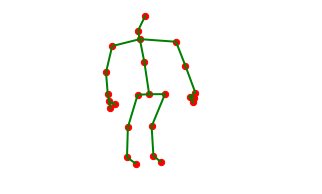

This creates the best results: putting the nodes in purely random locations isn't something representative of the dataset, and will only make the model confused (extremely low/high gradinets, with un-interpretable outputs and low confidence of classification)
<br>
<br>
Using a dataset sequence as a starting is also viable, and i also experimented with that

The following code reads and optionally visualize a sequence of NTU-RGB+d. <br>
I followed [this](https://www.cnblogs.com/picassooo/p/14044566.html) code

In [ ]:
#Taken from:  https://www.cnblogs.com/picassooo/p/14044566.html
#Read the skeleton:
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
 
 
def read_skeleton(file):
    with open(file, 'r') as f:
        skeleton_sequence = {}
        skeleton_sequence['numFrame'] = int(f.readline())
        skeleton_sequence['frameInfo'] = []
        for t in range(skeleton_sequence['numFrame']):
            frame_info = {}
            frame_info['numBody'] = int(f.readline())
            frame_info['bodyInfo'] = []
            for m in range(frame_info['numBody']):
                body_info = {}
                body_info_key = [
                    'bodyID', 'clipedEdges', 'handLeftConfidence',
                    'handLeftState', 'handRightConfidence', 'handRightState',
                    'isResticted', 'leanX', 'leanY', 'trackingState'
                ]
                body_info = {
                    k: float(v)
                    for k, v in zip(body_info_key, f.readline().split())
                }
                body_info['numJoint'] = int(f.readline())
                body_info['jointInfo'] = []
                for v in range(body_info['numJoint']):
                    joint_info_key = [
                        'x', 'y', 'z', 'depthX', 'depthY', 'colorX', 'colorY',
                        'orientationW', 'orientationX', 'orientationY',
                        'orientationZ', 'trackingState'
                    ]
                    joint_info = {
                        k: float(v)
                        for k, v in zip(joint_info_key, f.readline().split())
                    }
                    body_info['jointInfo'].append(joint_info)
                frame_info['bodyInfo'].append(body_info)
            skeleton_sequence['frameInfo'].append(frame_info)
    return skeleton_sequence
 
 #max body here
def read_xyz(file, max_body=1, num_joint=25):
    seq_info = read_skeleton(file)
    data = np.zeros((3, seq_info['numFrame'], num_joint, max_body))
    for n, f in enumerate(seq_info['frameInfo']):
        for m, b in enumerate(f['bodyInfo']):
            for j, v in enumerate(b['jointInfo']):
                if m < max_body and j < num_joint:
                    data[:, n, j, m] = [v['x'], v['y'], v['z']]
                else:
                    pass
    return data

In [ ]:
#Visualize the skeleton:
point = read_skeleton("path-to-dataset")
#point = media.reshape(3,1,25,1).cpu().detach().numpy()
xmax = np.max(point1[0, :, :, :]) + 0.5
xmin = np.min(point1[0, :, :, :]) - 0.5
ymax = np.max(point1[1, :, :, :]) + 0.3
ymin = np.min(point1[1, :, :, :]) - 0.3
zmax = np.max(point1[2, :, :, :])
zmin = np.min(point1[2, :, :, :])
 
row = point1.shape[1]
print(point1.shape)
 
 
# 相邻各节点列表，用来画节点之间的连接线
arms = [23, 11, 10, 9, 8, 20, 4, 5, 6, 7, 21]
rightHand = [11, 24]
leftHand = [7, 22]
legs = [19, 18, 17, 16, 0, 12, 13, 14, 15]
body = [3, 2, 20, 1, 0]
 
# 2D展示------------------------------------------------------------------------
n = 0     # 从第n帧开始展示
m = m  # 到第m帧结束，n<m<row
plt.figure()
plt.ion()
for i in range(n, tot_frames):
    plt.cla()
    plt.scatter(point1[0, i, :, :], point1[1, i, :, :], c='red', s=40.0)
    plt.plot(point1[0, i, arms, 0], point1[1, i, arms, 0], c='green', lw=2.0)
    plt.plot(point1[0, i, rightHand, 0], point1[1, i, rightHand, 0], c='green', lw=2.0)
    plt.plot(point1[0, i, leftHand, 0], point1[1, i, leftHand, 0], c='green', lw=2.0)
    plt.plot(point1[0, i, legs, 0], point1[1, i, legs, 0], c='green', lw=2.0)
    plt.plot(point1[0, i, body, 0], point1[1, i, body, 0], c='green', lw=2.0)
    #print second body
    '''    
    plt.plot(point[0, i, arms, 1], point[1, i, arms, 1], c='green', lw=2.0)
    plt.plot(point[0, i, rightHand, 1], point[1, i, rightHand, 1], c='green', lw=2.0)
    plt.plot(point[0, i, leftHand, 1], point[1, i, leftHand, 1], c='green', lw=2.0)
    plt.plot(point[0, i, legs, 1], point[1, i, legs, 1], c='green', lw=2.0)
    plt.plot(point[0, i, body, 1], point[1, i, body, 1], c='green', lw=2.0)
 '''    
    plt.text(xmax-0.5, ymax-0.1, 'frame: {}/{}'.format(i, row-1))
    # plt.text(xmax-0.8, ymax-0.4, 'label: ' + str(label[i]))
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.pause(0.001)
 
plt.ioff()
plt.show()

### H2O

Differently from the previously dataset, i don't have a neutral position. What i did was taking a random sequence, and position the hands and the box in the mean coordinates of it; then, i replicated this pose for N frames

*again, this is a sequence but appears still because the pose is the same in every frame*

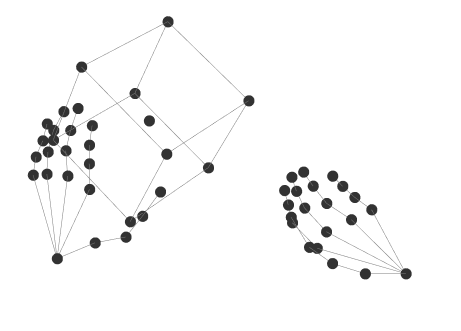

In [ ]:
#Read the sequence:
import os
import numpy as np
import torch
video = []
for file in os.listdir("path-to-dataset"):
   nome = int(file[0:6])
   if file.endswith(".txt") and (nome>= start_frame and nome<=end_frame):
      video.append(np.loadtxt("path-to-dataset/obj_pose/"+file))

cam_dict['objects'] = np.delete(np.array(video), [0], axis=1) 

cam_dict['objects'] = cam_dict['objects'][:,:27] #remove mid edge point
seq = np.concatenate((cam_dict['hands'], cam_dict['objects']), axis=1)

In [ ]:
#Create the mean sequence
mean_coo = {x : [0,0,0] for x in range(0,51)} #51 nodes
for x in range(1,(tot_frames)+1 ):
  seq = np.concatenate((cam_dict["hands"][x-1],cam_dict["objects"][x-1])) #the object and the hands resides in two different section, so they must be 
  #concatenated for later use
  #-------------------------------------------
  #Compute the mean
  for  y in range(0,51):
        mean_coo[y][0] += seq[y*3]   #x coo
        mean_coo[y][0]/=x
        mean_coo[y][1] += seq[y*3 +1]   #y coo
        mean_coo[y][1]/=x
        mean_coo[y][2] += seq[y*3 + 2]   #z coo
        mean_coo[y][2]/=x
#Now put the mean from a dict{ node: mean position  } to an ordered list
coo_list = []
for y in mean_coo.keys():
  coo_list.append(mean_coo[y][0]) 
  coo_list.append(mean_coo[y][1]) 
  coo_list.append(mean_coo[y][2]) 

In [ ]:
#Replicate it for the chosen number of frames
clean_input = torch.FloatTensor(coo_list)
clean_input = clean_input.repeat(tot_frames,1)
#Resulting hape: frames x 156

To visualize the graph i used the [igraph](https://igraph.org/) library 

In [ ]:
pip install igraph
pip install  chart_studio
pip install -U kaleido

In [ ]:
import igraph as ig
import numpy as np
import chart_studio.plotly as py
from plotly.offline import iplot
import plotly.graph_objs as go
import os
import numpy as np

In [ ]:

num_node = 51 
#This creates the connection between nodes
#right hand
loop_link = [(i, i) for i in range(num_node)]
neighbor_link = [(0, 1), (1, 2), (2, 3), (3, 4), (0, 5),
                  (5, 6), (6, 7), (7,8), (0, 9), (9, 10),
                  (10, 11), (11,12), (0, 13), (13,14), (14,15),
                  (15,16), (0, 17), (17,18), (18,19), (19,20)]
#left hand
left_hand= [(x+21, y+21) for (x,y) in neighbor_link]
#box connections
box = [(43,44 ), (44, 45), (45, 46), (46, 43), (46, 50), (43,47), (47,48), (48,49), (49,50), (50,47), (44, 48),(49,45)] #isthe first coordinate the center? 9 nodes, 42 center

edges =  neighbor_link + left_hand + box
center = 0 # 
N=51 #
nodes = [x for x in range(0,51)]

#This section creates some data in the format requested from the library
array_dict = []
for x in nodes:
  array_dict.append({"name": str(x), "group": str(x)})
  
right_dict = {"nodes": array_dict}

array_dict = []
for (x,y) in edges:

  array_dict.append({"source": x, "target": y,"value":1 })


right_dict["links"]= array_dict

data = right_dict
N=len(data['nodes']) #


L=len(data['links'])
Edges=[(data['links'][k]['source'], data['links'][k]['target']) for k in range(L)]



for j in range(0,tot_frames): #expected shape: frames x 153
  seq = clean_input[j]#

  G=ig.Graph(Edges, directed=False)

  layt=[x for x in range(0,N)] #
  l= [x * (10^0) for x in seq.tolist()] #
  start = 0 #0

 
  for x in range(0,N): #
    layt[x] = l[start:start+3] #
    start+=3
  
  labels=[]
  group=[]

  for node in data['nodes']:
    labels.append(node['name'])
    group.append(node['group'])

  

  Xn=[]
  Yn=[]
  Zn=[]

  for k in range(0,N):
    Xn+=[layt[k][0]]
    Yn+=[layt[k][1]]
    Zn+=[layt[k][2]]

  Xe=[]
  Ye=[]
  Ze=[]

  for e in Edges:
    Xe+=[layt[e[0]][0],layt[e[1]][0],None]# x-coordinates of edge ends
    Ye+=[layt[e[0]][1],layt[e[1]][1],None]
    Ze+=[layt[e[0]][2],layt[e[1]][2],None]

  trace1=go.Scatter3d(x=Xe, y=Ye, z=Ze, mode='lines', line=dict(color='rgb(125,125,125)', width=1),hoverinfo='none')

  trace2=go.Scatter3d(x=Xn, y=Yn, z=Zn, mode='markers', name='actors', 
                    marker=dict(symbol='circle', size=6, color='rgb(50,50,50)', colorscale='Viridis', 
                        line=dict(color='rgb(50,50,50)', width=0.5)), text=labels, hoverinfo='text')

  axis=dict(showbackground=False, showline=False, zeroline=False, showgrid=False, showticklabels=False, title='')

  layout = go.Layout(
          title="Network of coappearances of characters in Victor Hugo's novel<br> Les Miserables (3D visualization)",
          width=1000,
          height=1000,
          showlegend=False,
          scene=dict(
              xaxis=dict(axis),
              yaxis=dict(axis),
              zaxis=dict(axis),
          ))

  data1=[trace1, trace2]

  fig=go.Figure(data=data1, layout=layout)
  
  iplot(fig, filename='Les-Miserables')
  



## [Code] Viualization: by layer, neuron and class logits for H2O 

The following section uses a model with low accuracy (circa 50% over 37 classes). The reason is that to experiment a bit, i needed a small dataset due to constraints of computational power and mostly time.

So, the input can be optimized with different objectives. Which one do we use?

In [ ]:
#Initialize the model
model = Model(3, 37,{'layout':'h2o', 'strategy': 'uniform',  'tipo': 'all'} , True, dropout=0.)#.to("cuda")
for index,layer in enumerate(model.named_children()):
  print(layer)

('data_bn', BatchNorm1d(153, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
('st_gcn_networks', ModuleList(
  (0): st_gcn(
    (gcn): ConvTemporalGraphical(
      (conv): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
    )
    (tcn): Sequential(
      (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(9, 1), stride=(1, 1), padding=(4, 0))
      (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): Dropout(p=0, inplace=True)
    )
    (relu): ReLU(inplace=True)
  )
  (1): st_gcn(
    (gcn): ConvTemporalGraphical(
      (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    )
    (tcn): Sequential(
      (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(9, 1), stride=(1, 1), padding=(4, 0))
      (3): BatchNorm2d(64

### Optimize by class

#### Code

The following code is an example of optimization by class (in particular, *reading a book*)

In [ ]:
#A layer hook is defined. Here it's used to keep trace of the output gradients 
def layer_hook(act_dict, layer_name):
    def hook(module, input, output):
        act_dict[layer_name] = output
    return hook

In [ ]:
#Initialize and load the model 
model = Model(3, 37,{'layout':'h2o', 'strategy': 'uniform',  'tipo': 'all'} , True, dropout=0.)#.to("cuda")
model.load_state_dict(torch.load("path-to-model", map_location=torch.device('cpu')))
activation_dictionary = {}
layer_name = 'classifier_6'

input = clean_input#.to("cuda")
input = input.type(torch.FloatTensor)#.cuda
input = input.unsqueeze(0)

#Create an optimized for the input
input.requires_grad_(True)
optimizer = torch.optim.Adam([input], lr=0.1, weight_decay=1e-6)

#Register the hook on the chosen layer/neuron (in this case, the layer)
model.fcn.register_forward_hook(layer_hook(act_dict, layer_name))

#Chose the class
unit = 33 #read a book

for x in range(0,31): #Number of iterations for the optimization

  optimizer.zero_grad()
  model.eval()

  output = model(input.view(1, tot_frames, 51, 3).permute(0,3,1,2).unsqueeze(4)) #53, 3
   
  #Compute the loss
  loss = -torch.mean(act_dict[layer_name][0][unit])

  print('Iteration:', str(x), 'Loss:', "{0:.2f}".format(loss.data.numpy()))

  # Backward
  loss.backward()

  # Update input
  optimizer.step()

#### Results

What is the output of such iterations?

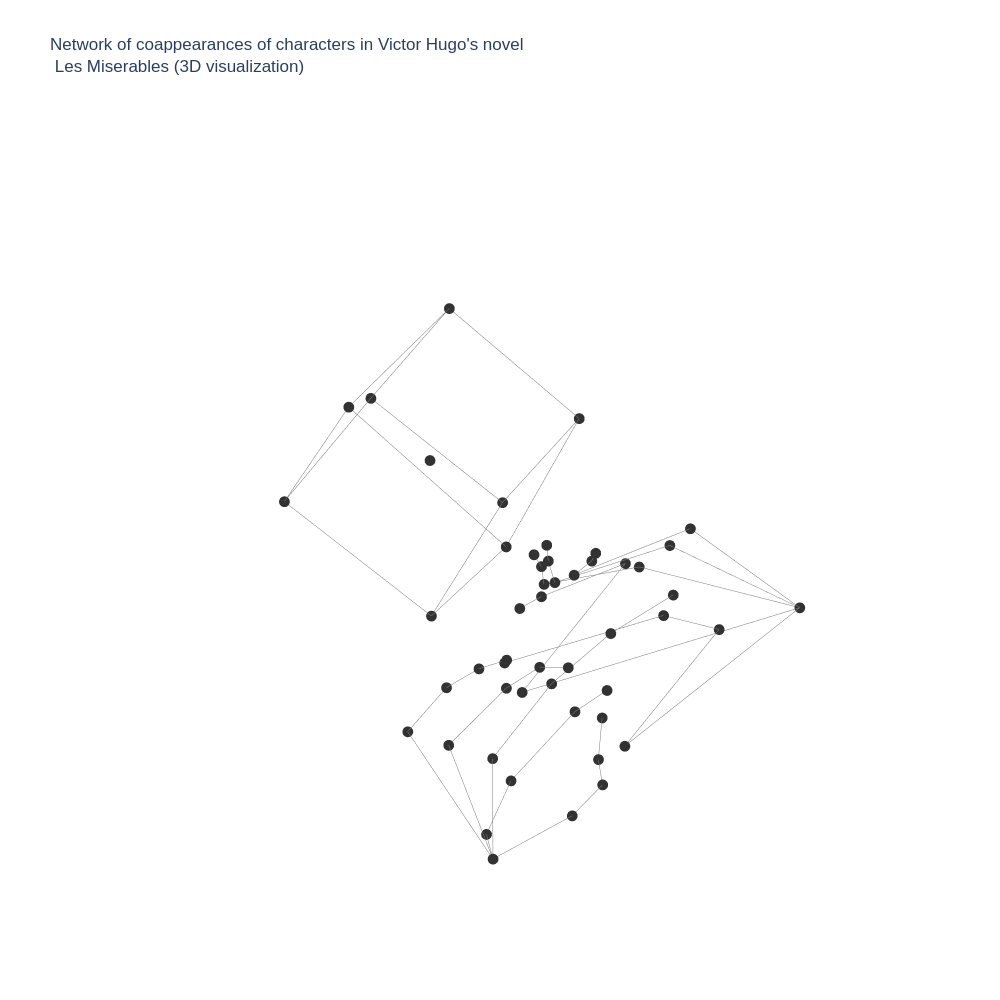

This is actually a good result: as "reading a book" in the dataset is represented sliding a finger over the book, this sequence imitates it with the right hand

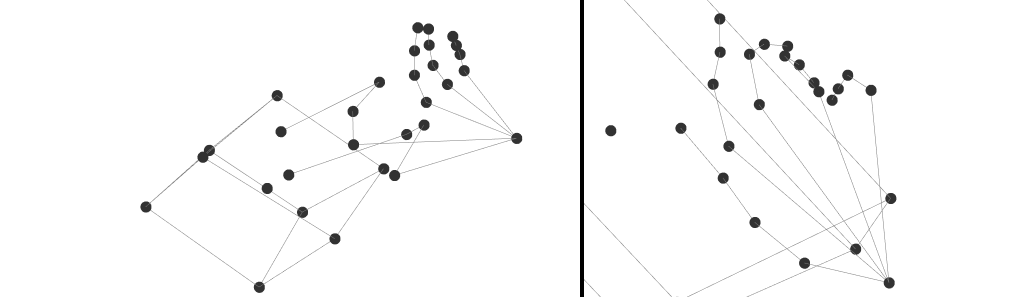

On the left: a frame from the optimization
<br>
On the right: a frame from a "read a book" sequence of the dataset

### Optimize by layer

#### Code

The following code is an example of optimization by layer (in particular, the last convolutional layer)

In [ ]:
#A layer hook is defined. Here it's used to keep trace of the output gradients 
def layer_hook(act_dict, layer_name):
    def hook(module, input, output):
        act_dict[layer_name] = output
    return hook

In [ ]:
#Initialize and load the model 
model = Model(3, 37,{'layout':'h2o', 'strategy': 'uniform',  'tipo': 'all'} , True, dropout=0.)#.to("cuda")
model.load_state_dict(torch.load("path-to-model", map_location=torch.device('cpu')))
activation_dictionary = {}
layer_name = 'classifier_6'

input = clean_input#.to("cuda")
input = input.type(torch.FloatTensor)#.cuda
input = input.unsqueeze(0)

#Create an optimized for the input
input.requires_grad_(True)
optimizer = torch.optim.Adam([input], lr=0.1, weight_decay=1e-6)

#Register the hook on the chosen layer/neuron (in this case, the layer)
model.st_gcn_networks[9].register_forward_hook(layer_hook(act_dict, layer_name))


for x in range(0,31): #Number of iterations for the optimization

  optimizer.zero_grad()
  model.eval()

  output = model(input.view(1, tot_frames, 51, 3).permute(0,3,1,2).unsqueeze(4)) #53, 3
   
  #Compute the loss
  loss = -torch.mean(act_dict[layer_name][0])

  print('Iteration:', str(x), 'Loss:', "{0:.2f}".format(loss.data.numpy()))

  # Backward
  loss.backward()

  # Update input
  optimizer.step()

#### Results

What is the output of this optimization?

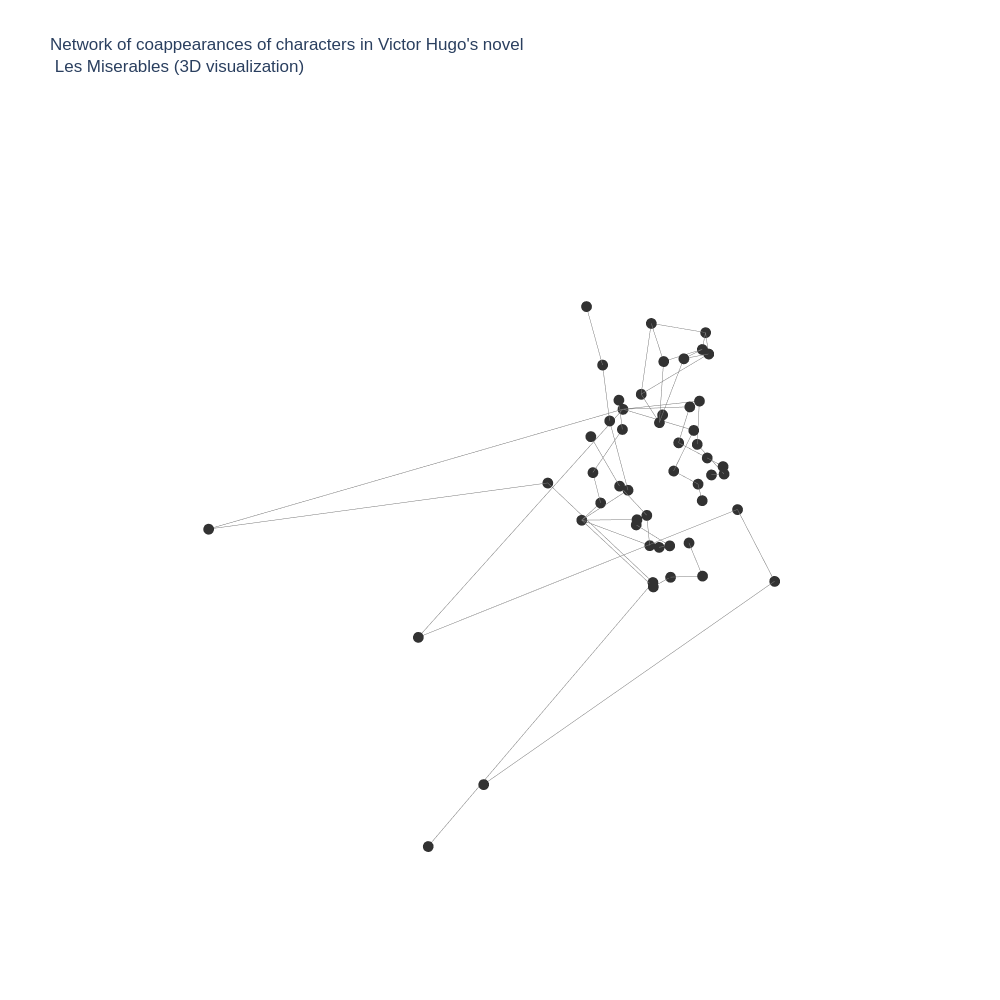

This is not much interpretable!

### Optimize by neuron

#### Code

The following code is an example of optimization by neuron

In [ ]:
#A layer hook is defined. Here it's used to keep trace of the output gradients 
def layer_hook(act_dict, layer_name):
    def hook(module, input, output):
        act_dict[layer_name] = output
    return hook

In [ ]:
#Initialize and load the model 
model = Model(3, 37,{'layout':'h2o', 'strategy': 'uniform',  'tipo': 'all'} , True, dropout=0.)#.to("cuda")
model.load_state_dict(torch.load("path-to-model", map_location=torch.device('cpu')))
activation_dictionary = {}
layer_name = 'classifier_6'

input = clean_input#.to("cuda")
input = input.type(torch.FloatTensor)#.cuda
input = input.unsqueeze(0)

#Create an optimized for the input
input.requires_grad_(True)
optimizer = torch.optim.Adam([input], lr=0.05, weight_decay=1e-6)

#Register the hook on the chosen layer/neuron (in this case, the layer)
model.st_gcn_networks[9].register_forward_hook(layer_hook(act_dict, layer_name))

#Chose the class
unit = 33 #read a book

for x in range(0,31): #Number of iterations for the optimization

  optimizer.zero_grad()
  model.eval()

  output = model(input.view(1, tot_frames, 51, 3).permute(0,3,1,2).unsqueeze(4)) #53, 3
   
  #Compute the loss
  loss = -torch.mean(act_dict[layer_name][0][0][42])

  print('Iteration:', str(x), 'Loss:', "{0:.2f}".format(loss.data.numpy()))

  # Backward
  loss.backward()

  # Update input
  optimizer.step()

#### Results

What tells us the result of these iterations?

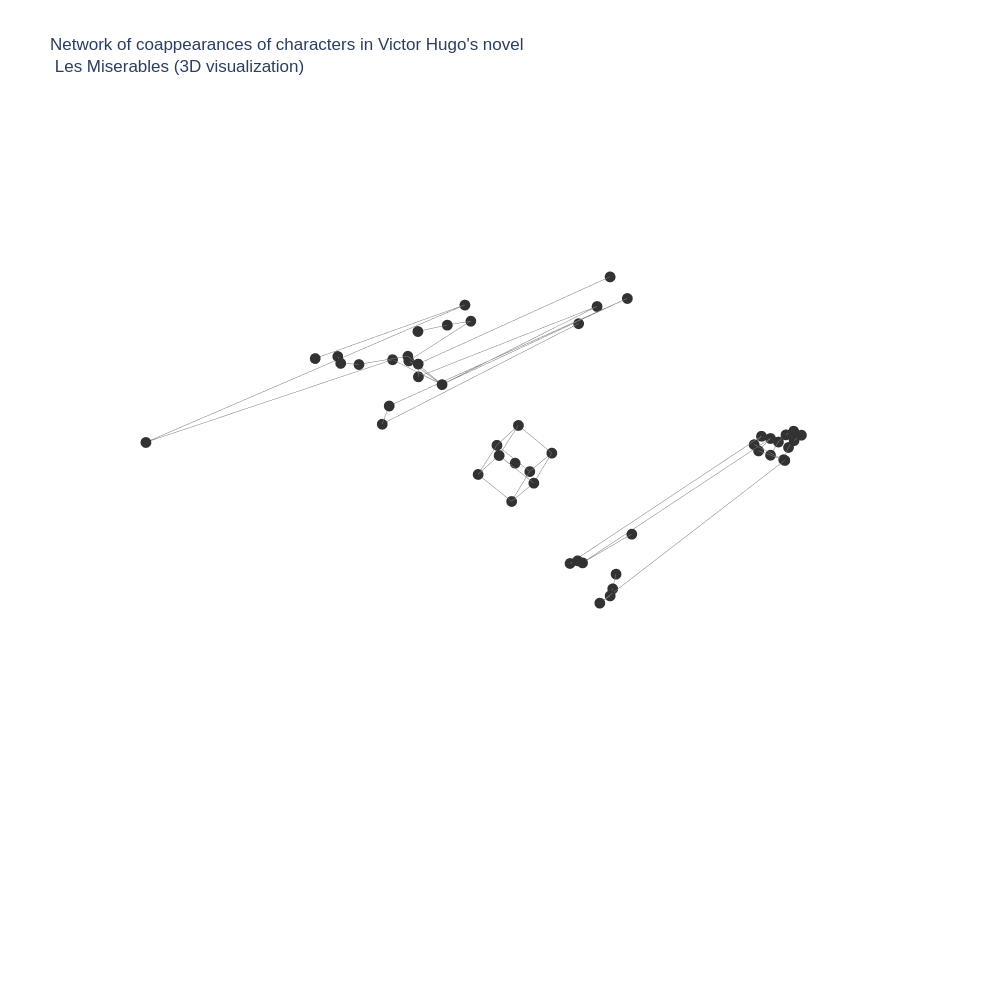

<h3>Actually, this is not nonsense: what can be observed is that the proportions of the box are coherent in almost every frame, with just a skewed joint in some frame. Also, meanwhile the right hand is apparently totally random, the left one preserves the joint distances between the wrist and knuckels.
<br>
<h4>This may be attributed to the fact that the dataset contains right-handed subjects, and the the left one performs not-so intricated tasks
<br>
<br>
<h2>
Also, the coherent proportions are especially impressive since in this particular model there's no prior on the distance between nodes

## [Code] VIsualization for NTU-RGB+d

The following section uses a model with high accuracy (86% over 60 classes)

In [ ]:
#First of all, obtain a neutral pose; the code is simply this to avoid to write a long tensor and making the notebook laggy
clean_input  =  point[:,10,:,:].reshape(3, 1, 25, 1)
clean_input= clean_input.repeat(1,tot_frames,1,1)

### Visualization by class

#### Code

In [ ]:
#A layer hook is defined. Here it's used to keep trace of the output gradients 
def layer_hook(act_dict, layer_name):
    def hook(module, input, output):
        act_dict[layer_name] = output
    return hook

In [ ]:
#Initialize and load the model 
model = Model(3, 60,{'layout':'ntu-rgb+d', 'strategy': 'spatial'} , True, dropout=0.05)#.to("cuda")
model.load_state_dict(torch.load("path-to-st_gcn.ntu-xview.pt",map_location=torch.device('cpu')))
activation_dictionary = {}
layer_name = 'classifier_6'

input = clean_input#.to("cuda")
input = input.type(torch.FloatTensor)#.cuda
input = input.unsqueeze(0)

#Create an optimized for the input
input.requires_grad_(True)
optimizer = torch.optim.Adam([input], lr=0.0005, weight_decay=1e-6)

#Register the hook on the chosen layer/neuron (in this case, the layer)
model.fcn.register_forward_hook(layer_hook(act_dict, layer_name))

#Chose the class
unit = 8 #sit down

for x in range(0,31): #Number of iterations for the optimization

  optimizer.zero_grad()
  model.eval()

  output = model(input.view(1, tot_frames, 51, 3).permute(0,3,1,2).unsqueeze(4)) #53, 3
   
  #Compute the loss
  loss = -torch.mean(act_dict[layer_name][0][8])

  print('Iteration:', str(x), 'Loss:', "{0:.2f}".format(loss.data.numpy()))

  # Backward
  loss.backward()

  # Update input
  optimizer.step()

#### Results 

Ideally, the reconstructed sequence should represent the act of sitting down. Instead, this is the reconstruction
<br>
Also, notice that the predicted class's probability is 100%

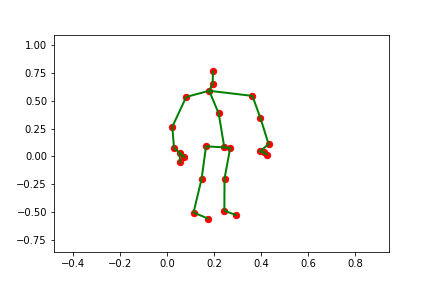

Could this be due to overfitting? Has it just learned the first frames of the sequence? More details in the *Other experiments* section

### Visualization by layer

#### Code

In [ ]:
#A layer hook is defined. Here it's used to keep trace of the output gradients 
def layer_hook(act_dict, layer_name):
    def hook(module, input, output):
        act_dict[layer_name] = output
    return hook

In [ ]:
#Initialize and load the model 
model = Model(3, 60,{'layout':'ntu-rgb+d', 'strategy': 'spatial'} , True, dropout=0.05)#.to("cuda")
model.load_state_dict(torch.load("path-to-st_gcn.ntu-xview.pt",map_location=torch.device('cpu')))
activation_dictionary = {}
layer_name = 'classifier_6'

input = clean_input#.to("cuda")
input = input.type(torch.FloatTensor)#.cuda
input = input.unsqueeze(0)

#Create an optimized for the input
input.requires_grad_(True)
optimizer = torch.optim.Adam([input], lr=0.005, weight_decay=1e-6)

#Register the hook on the chosen layer/neuron (in this case, the layer)
model.fcn.register_forward_hook(layer_hook(act_dict, layer_name))

#Chose the class
unit = 8 #sit down

for x in range(0,31): #Number of iterations for the optimization

  optimizer.zero_grad()
  model.eval()

  output = model(input.view(1, tot_frames, 51, 3).permute(0,3,1,2).unsqueeze(4)) #53, 3
   
  #Compute the loss
  loss = -torch.mean(act_dict[layer_name][0])

  print('Iteration:', str(x), 'Loss:', "{0:.2f}".format(loss.data.numpy()))

  # Backward
  loss.backward()

  # Update input
  optimizer.step()

#### Results 

The results are not very interpretable

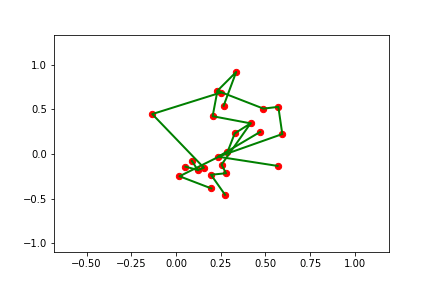

### Visualization by neuron 

#### Code

In [ ]:
#A layer hook is defined. Here it's used to keep trace of the output gradients 
def layer_hook(act_dict, layer_name):
    def hook(module, input, output):
        act_dict[layer_name] = output
    return hook

In [ ]:
#Initialize and load the model 
model = Model(3, 60,{'layout':'ntu-rgb+d', 'strategy': 'spatial'} , True, dropout=0.05)#.to("cuda")
model.load_state_dict(torch.load("path-to-st_gcn.ntu-xview.pt",map_location=torch.device('cpu')))
activation_dictionary = {}
layer_name = 'classifier_6'

input = clean_input#.to("cuda")
input = input.type(torch.FloatTensor)#.cuda
input = input.unsqueeze(0)

#Create an optimized for the input
input.requires_grad_(True)
optimizer = torch.optim.Adam([input], lr=0.005, weight_decay=1e-6)

#Register the hook on the chosen layer/neuron (in this case, the layer)
model.fcn.register_forward_hook(layer_hook(act_dict, layer_name))

#Chose the class
unit = 8 #sit down

for x in range(0,31): #Number of iterations for the optimization

  optimizer.zero_grad()
  model.eval()

  output = model(input.view(1, tot_frames, 51, 3).permute(0,3,1,2).unsqueeze(4)) #53, 3
   
  #Compute the loss
  loss = -torch.mean(act_dict[layer_name][0][0][42])

  print('Iteration:', str(x), 'Loss:', "{0:.2f}".format(loss.data.numpy()))

  # Backward
  loss.backward()

  # Update input
  optimizer.step()

#### Results 

This is not very interpretable, though it's notable that the proportions betweem joints are coherent

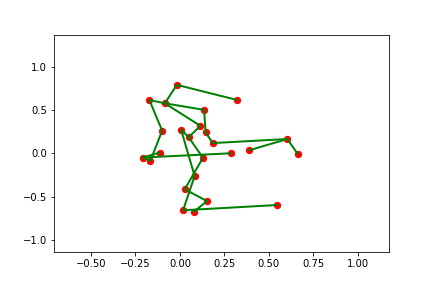

# Other experiments

During other experiments, two things bugged me: if the model is given a prior, will it show in this type of feature vsualization? And: are the under-whelming resutls of NTU-RGB model figment of overfitting? 

## Results on the prior (No code)

The following section has no code since what has changed is the dataset (and subsequently, the model): the distance between the joints has been normalized as the mean distance (per subject), so in every frame each joint will always have the same distance from the others connected joints
<br>
<br>
A new model is therefore trained on this dataset (and gains a 10% more accuracy)

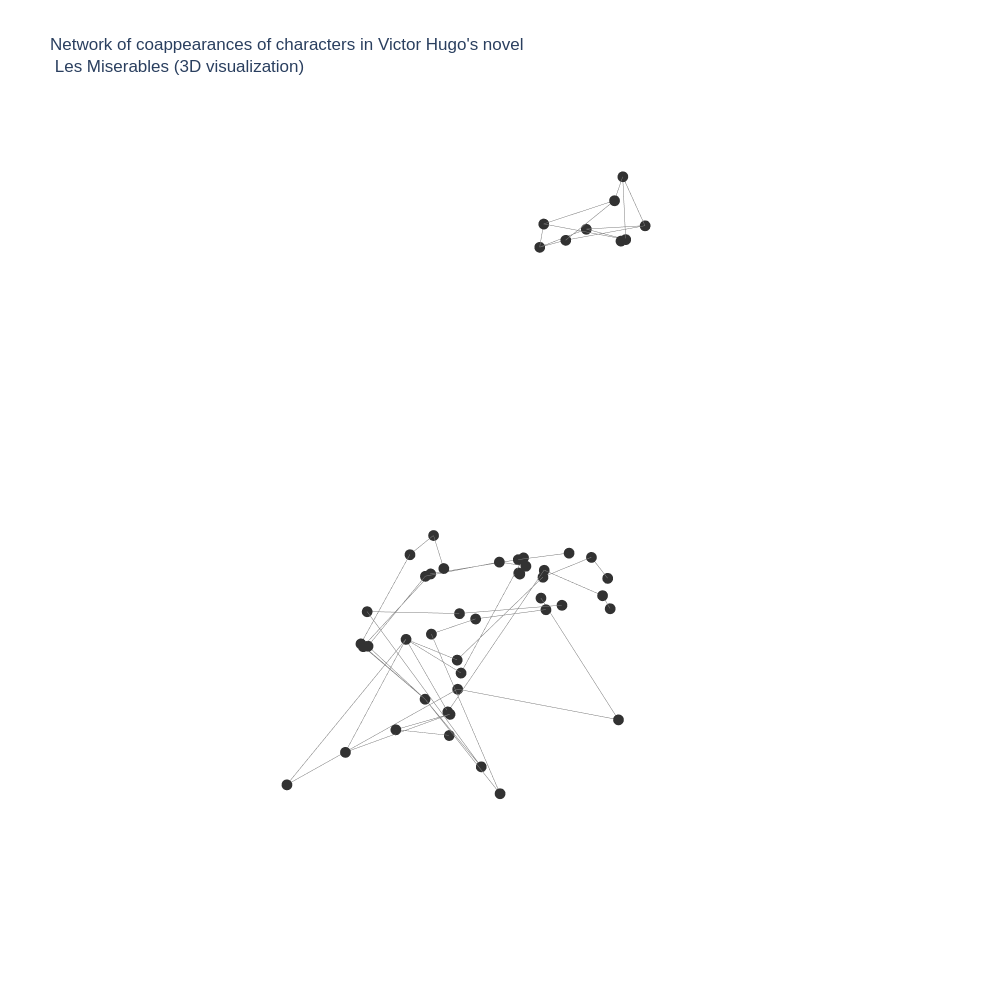

Did the model learn that the distance between the joints is constat? Proably yes, since the output is more spread out and less extremely-skewed on a single joint. How exactly does this help the model learn? The results certainly don't show
<br>
<br>
Notably, the box's proportions are not respected anymore. Could this mean that it relies less on the box and more on the hand? These results cannot tell for sure

## Results of an NTU-RGB overfitted model (No code)

The following section has no code since the only change is the model

Is the model trained on NTU-RGB+d overfitted? To answer this question, i personally overfitted an ST-GCN model over the same dataset. How does the reconstructed sequence look?

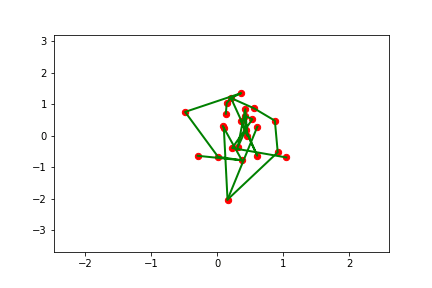

Now, expectedly, the reconstructed sequence is not some frames from the dataset, but an extremely skewed sequence. <br>
I suppose this is due to the fact that an overfitted model is not capable of generalizing, so the most interesting features are not something logical or observable, but some gimmick the model looks for to recognize a dataset sample

# Conclusions and future works

So, can the methods used for networks of images be used in the context on skeleton sequences without much changing? The answer is clearly no: learned features are not so evident using input optimization, as opposed to images, where learned features can be clearly ***seen*** with this same method.
<br>
<br>
Some results did show what the model learned: in both H2O and NTU-RGB, the optimization showed that the models learned to mantain a coherent disance between nodes. <br>
Also, in the reconstructed sequences each frame is very different from the next one, it's not a smooth transition; this is because models were trained on datasets that sample frames over a smooth sequence, effectively giving it its "laggy" nature, and this behaviour is reflected when the models try to reconstruct a sequence
<br>
<br>
On the other side, some other results didn't show much: in NTU-RGB, it's not possible to tell what exactly the model learns looking at layer, neuron and by-class optimizations. 

<h2> But why these methods cannot be used as they are?

In my opinion, there are a couple of obvious fact that can't be overlooked: the very nature of images, and how the implmentation of these visualization methods tend to adjust the output of the optimization to make them more meaningful

When the optimization is performed, the gradients of the output optimization get clipped to fit between the 255 - 0 range (or 1 - 0) to visualize it as the colors in the image; this approach has two main problems: the loss of information, and **how do i clip gradinets for something different from pixels? Is this actually meaningful?**
<br>
<br>
Other modification on the output of the optimization include: normalize it following the mean and the standard deviation of the dataset (on skeleton sequences this is no trivial task),and  reduce the checkboard artifacts using regularization (but how do these artifacts manifest in skeleton sequences? How can they be regularized?)

<h2> Future works must take into account all these considerations, and (possibly) develop ad-hoc techniques in the context of graphs
<br>
<br>
<h2> Images can be represented as graphs, so an effective feature visualization on graphs not only benefits a wider set of applications, but can also improve the actual feature visualization over images